In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import FinanceDataReader as fdr
#from Iterative_Backtester import IterativeBase
#from Iterative_SMABOL import IterativeBacktest 

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_21292\2734329987.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [2]:
data = fdr.DataReader('AAPL','2000-01-01','2022-01-01')['Close']
data.to_csv("AAPL.csv")

In [58]:
class IterativeBase():
    """
    Base class for iterative (event-driven) backtesting of trading strategies.
    """
    
    def __init__(self, symbol, start, end, amount, data, charge = 0.00025):
        '''
        Parameters
        ----------
        symbol: str
            ticker symbol (instrument) to be backtested
        start: str
            start date for data import
        end: str
            end date for data import
        amount: float
            initial amount to be invested per trade
        data: str
            The location of dataset
        charge: charge*amount (default = 0.00025) 
            trading cost

    '''
        self.symbol = symbol
        self.start = start
        self.end = end
        self.initial_balance = amount
        self.current_balance = amount
        self.data_link = data
        self.units = 0
        self.trades = 0
        self.position = 0
        self.charge = charge
        self.get_data()
        
    def get_data(self):
        ''' Imports the data from data source(source can be changed).
        '''
        raw = pd.read_csv(self.data_link, parse_dates = ['Date'], index_col = "Date").dropna()
        raw = raw.loc[self.start:self.end].copy()
        raw["returns"] = np.log(raw.Close / raw.Close.shift(1))
        self.data = raw
        
    def plot_data(self, cols = None):  
        ''' Plots the closing price for the symbol.
        '''
        if cols is None:
            cols = "Close"
        self.data[cols].plot(figsize = (12, 8), title = self.symbol)
        
    def get_values(self, bar):
        ''' Returns the date, the price and the spread for the given bar.
        '''
        date = str(self.data.index[bar].date())
        price = round(self.data.Close.iloc[bar], 5)
        return date, price
    
    def print_current_balance(self, bar):
        ''' Prints out the current (cash) balance.
        '''
        date, price = self.get_values(bar)
        print("{} | Current Balance: {}".format(date, round(self.current_balance, 2)))
        
    def buy_instrument(self, bar, units = None, amount = None):
        ''' Places and executes a buy order (market order).
        '''
        if self.current_balance <= 0:
            return
        date, price = self.get_values(bar)
        if amount is not None: # use units if units are passed, otherwise calculate units
            units = int(amount / price)
        if self.charge:
            total_price = units*price*(1+self.charge)
            
        if total_price >= self.current_balance:
            while total_price >= self.current_balance:
                units -= 1
                total_price = units*price*(1+self.charge)
                if units <= 0:
                    return
        if units <= 0:
            return
        self.current_balance -= total_price # reduce cash balance by "purchase price"
        self.units += units
        self.trades += 1
        print("{} |  Buying {} for {}".format(date, units, round(price, 5)))
        
    def sell_instrument(self, bar, units = None, amount = None):
        ''' Places and executes a sell order (market order).
        '''
        date, price = self.get_values(bar)
        if amount is not None: # use units if units are passed, otherwise calculate units
            units = int(amount / price)
        if self.charge:
            total_price = units*price*(1-self.charge)
        if self.units <=0 or units<=0:
            return
        self.current_balance += total_price # increases cash balance by "purchase price"
        self.units -= units
        self.trades += 1
        print("{} |  Selling {} for {}".format(date, units, round(price, 5)))
        
    def print_current_position_value(self, bar):
        ''' Prints out the current position value.
        '''
        date, price = self.get_values(bar)
        cpv = self.units * price
        print("{} |  Current Position Value = {}".format(date, round(cpv, 2)))
        
    def print_current_nav(self, bar):
        ''' Prints out the current net asset value (nav).
        '''
        date, price = self.get_values(bar)
        nav = self.current_balance + self.units * price
        print("{} |  Net Asset Value = {}".format(date, round(nav, 2)))
        
    def close_pos(self, bar):
        ''' Closes out a long or short position (go neutral).
        '''
        date, price = self.get_values(bar)
        print(75 * "-")
        print("{} | +++ CLOSING FINAL POSITION +++".format(date))
        self.current_balance += self.units * price # closing final position (works with short and long!)
        self.current_balance -= self.units * price * self.charge # substract charge
        print("{} | closing position of {} for {}".format(date, self.units, price))
        self.units = 0 # setting position to neutral
        self.trades += 1
        perf = (self.current_balance - self.initial_balance) / self.initial_balance * 100
        self.print_current_balance(bar)
        print("{} | net performance (%) = {}".format(date, round(perf, 2) ))
        print("{} | number of trades executed = {}".format(date, self.trades))
        print(75 * "-")

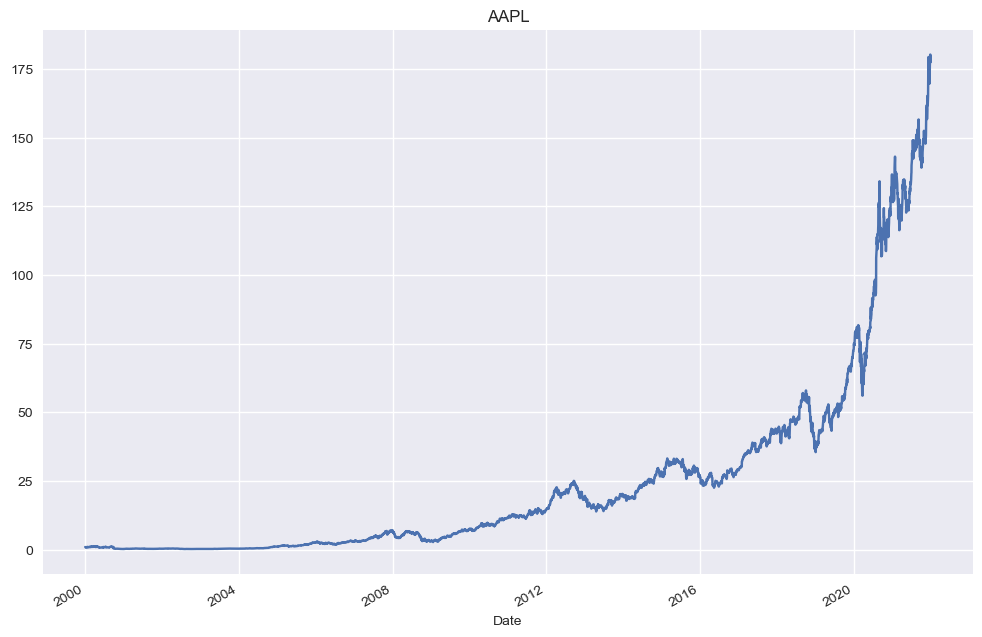

In [59]:
Base = IterativeBase('AAPL','2000-01-01','2022-01-02',100000,"AAPL.csv")
Base.plot_data()

In [60]:
Base.get_values(0)

('2000-01-03', 0.99944)

In [61]:
Base.print_current_balance(0)

2000-01-03 | Current Balance: 100000


In [62]:
Base.buy_instrument(10,units=100)

2000-01-18 |  Buying 100 for 0.92801


In [63]:
Base.sell_instrument(15, units=100)

2000-01-25 |  Selling 100 for 1.00223


In [64]:
Base.sell_instrument(16, units=5)

In [65]:
Base.print_current_balance(16)

2000-01-26 | Current Balance: 100007.37


In [66]:
Base.buy_instrument(100, units=10000)

2000-05-25 |  Buying 10000 for 0.77916


In [67]:
Base.print_current_nav(20)

2000-02-01 |  Net Asset Value = 101164.73


In [68]:
Base.close_pos(200)

---------------------------------------------------------------------------
2000-10-17 | +++ CLOSING FINAL POSITION +++
2000-10-17 | closing position of 10000 for 0.35938
2000-10-17 | Current Balance: 95806.73
2000-10-17 | net performance (%) = -4.19
2000-10-17 | number of trades executed = 4
---------------------------------------------------------------------------


In [80]:
class IterativeBacktest(IterativeBase):
    def go_long(self, bar, units = None, amount = None):
        if units:
            self.buy_instrument(bar, units = units)
        elif amount:
            if amount == "all":
                amount = self.current_balance
            self.buy_instrument(bar, amount = amount)
            
    def go_short(self, bar, units = None, amount = None):
        if units:
            self.sell_instrument(bar, units = units)
        elif amount:
            if amount == "all":
                amount = self.current_balance
            self.sell_instrument(bar, amount = amount) # go short
            
    def SMA_BOL(self, SMA_S, SMA_M, SMA_L, dev):
        ''' 
        Backtests an SMA crossover strategy with SMA_S (short) and SMA_L (long).
        
        Parameters
        ----------
        SMA_S: int
            moving window in bars (e.g. days) for shorter SMA
        SMA_L: int
            moving window in bars (e.g. days) for longer SMA
        '''
        stm = "Testing SMA With Bolinger strategy | {} | SMA_S = {} & SMA_M = {} & SMA_L = {} DEV = {}".format(self.symbol, SMA_S, SMA_M, SMA_L, dev)
        print("-" * 75)
        print(stm)
        print("-" * 75)
        
        self.position = 0  # initial neutral position
        self.trades = 0  # no trades yet
        self.current_balance = self.initial_balance  # reset initial capital
        self.get_data() # reset dataset
        
        self.data["SMA_S"] = self.data["Close"].rolling(SMA_S).mean()
        self.data["SMA_L"] = self.data["Close"].rolling(SMA_L).mean()
        
        self.data["SMA"] = self.data["Close"].rolling(SMA_M).mean()
        self.data["Lower_1"] = self.data["SMA"] - self.data["Close"].rolling(SMA_M).std() * (dev/2)
        self.data["Upper_1"] = self.data["SMA"] + self.data["Close"].rolling(SMA_M).std() * (dev/2)
        self.data["Lower_2"] = self.data["SMA"] - self.data["Close"].rolling(SMA_M).std() * dev
        self.data["Upper_2"] = self.data["SMA"] + self.data["Close"].rolling(SMA_M).std() * dev     

        self.data.dropna(inplace = True)
        
        for bar in range(len(self.data)-1): # all bars (except the last bar)
            trade_flag = self.trades
            if self.data["SMA_S"].iloc[bar] > self.data["SMA_L"].iloc[bar]: # signal to go long
                if self.position in [0,-1]:
                    self.position = 1  # long position
            elif self.data["SMA_S"].iloc[bar] < self.data["SMA_L"].iloc[bar]: # signal to go short
                if self.position in [0, 1]:
                    self.position = -1 # short position
            else:
                if self.position in [1,-1]:
                    self.position = 0 #neutral position
            if self.position == 1 and self.data['Close'].iloc[bar]<self.data['Lower_2'].iloc[bar]:
                self.go_long(bar, amount='all')
            elif self.position == 1 and self.data['Close'].iloc[bar]<self.data['Lower_1'].iloc[bar]:
                self.go_long(bar, amount=min(self.current_balance/10,0))
            if self.position == -1 and self.data['Close'].iloc[bar]<self.data['Upper_2'].iloc[bar]:
                self.go_short(bar, amount='all')
            elif self.position == -1 and self.data['Close'].iloc[bar]<self.data['Upper_1'].iloc[bar]:
                self.go_long(bar, amount=min(self.current_balance/10,0))
            if self.trades != trade_flag:
                self.print_current_nav(bar)
        self.close_pos(bar+1) # close position at the last bar
        
   

In [81]:
SMA = IterativeBacktest('AAPL','2000-01-01','2022-01-02',100000,"AAPL.csv")
SMA.SMA_BOL(50, 100, 200, 2)

---------------------------------------------------------------------------
Testing SMA With Bolinger strategy | AAPL | SMA_S = 50 & SMA_M = 100 & SMA_L = 200 DEV = 2
---------------------------------------------------------------------------
2002-06-07 |  Buying 261618 for 0.38214
2002-06-07 |  Net Asset Value = 99975.01
2002-06-21 |  Buying 1 for 0.30089
2002-06-21 |  Net Asset Value = 78718.54
---------------------------------------------------------------------------
2021-12-31 | +++ CLOSING FINAL POSITION +++
2021-12-31 | closing position of 261619 for 177.57001
2021-12-31 | Current Balance: 46444074.53
2021-12-31 | net performance (%) = 46344.07
2021-12-31 | number of trades executed = 3
---------------------------------------------------------------------------
